# Impor Libraries

In [29]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import plot_roc_curve, cal_acc_pres_f1

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

Done loading data from cached files.
None
In epoch 0, loss: 392181.25
In epoch 10, loss: 95612.78125
In epoch 20, loss: 34384.02734375
In epoch 30, loss: 4720.66259765625
In epoch 40, loss: 4779.35107421875
In epoch 50, loss: 2328.60986328125
In epoch 60, loss: 1186.439697265625
In epoch 70, loss: 872.3123168945312


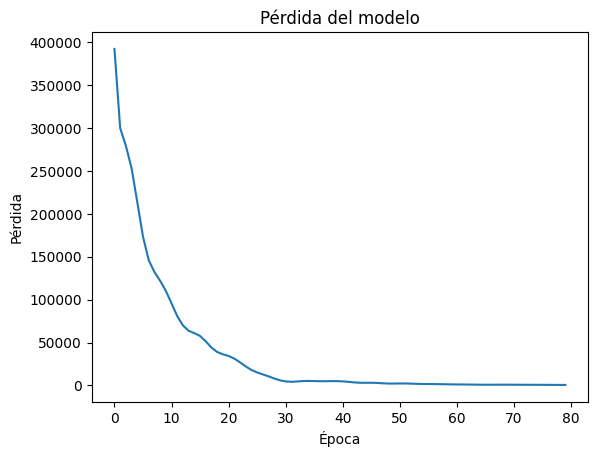

In [38]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

CASOS = {
  "caso1": {"task" : "ClasificacionBinario",
            "model": GraphSAGE,
            "predictor": DotPredictor(),
            "num_features_in" : gnn.dgl_graph.ndata["feat"].size(1),
            "num_feat_hidden" : 16, 
            "num_feat_out" : 1 },
  "caso2": {"task" : "ClasificacionBinario",
            "model": GraphSAGE,
            "predictor": MLPPredictor, 
            "num_features_in" : gnn.dgl_graph.ndata["feat"].size(1),
            "num_feat_hidden" : 16, 
            "num_feat_out" : 8 }
}

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



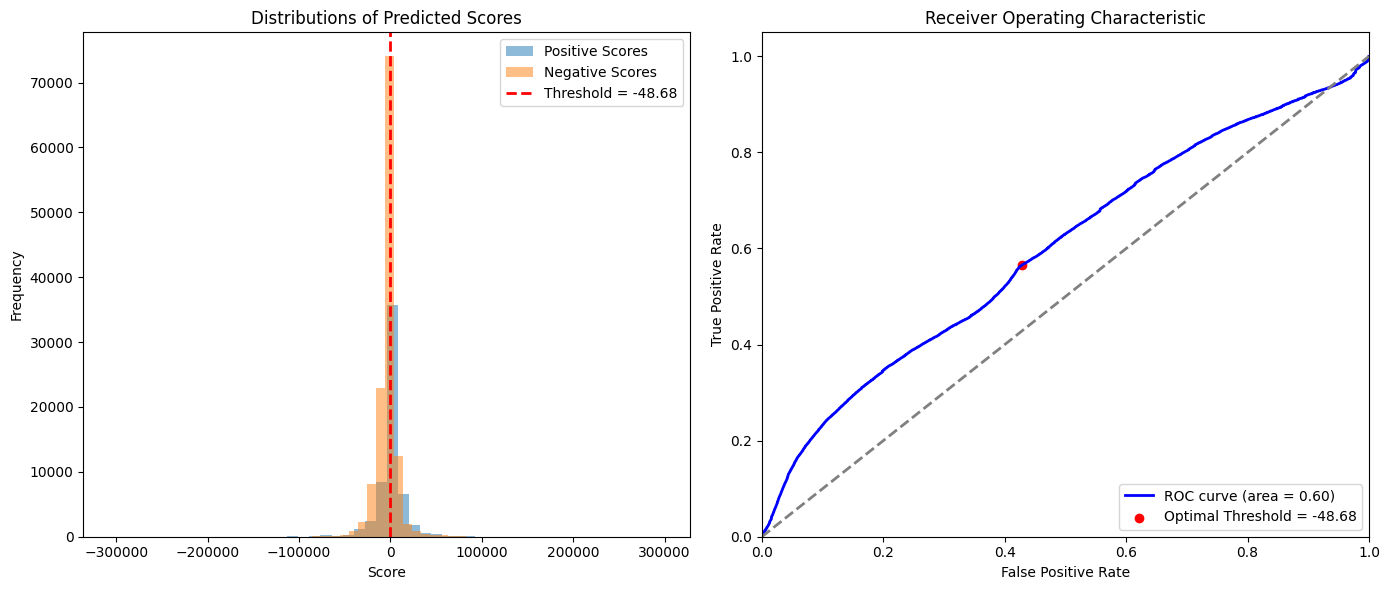

AUC: 0.597890513086388
ACCURACY 0.5697270794463488
PRESICION 0.3818637136424206
RECALL 0.565686474712409
F1 SCORE 0.45594447797223897


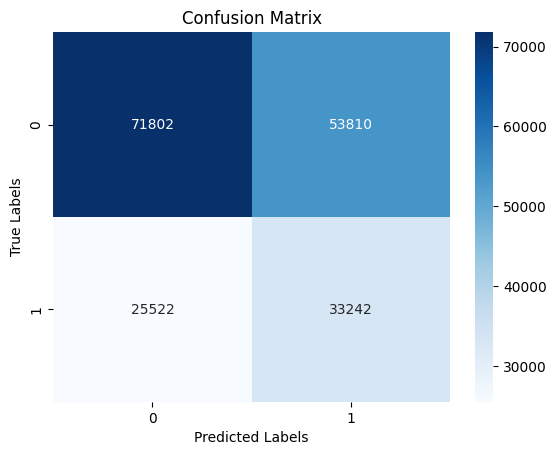

In [37]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : MLPPredictor
    

Done loading data from cached files.
None


DGLError: [14:51:27] C:\Users\zhoupeiyuan\workspace\DGL_scripts\release\win-64\dgl\src\array\kernel.cc:43: Check failed: (out->dtype).code == kDGLFloat || (out->dtype.code == kDGLBfloat): Feature data must be float type